In [1]:
import tensorflow as tf
from tensorflow import keras as keras
print(tf.__version__)

print(keras.__version__)

2.12.0
2.12.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import History

In [4]:
# Wczytaj dane treningowe i testowe
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

train_set = pd.read_csv('adult.data', sep=", ",header = None)
test_set = pd.read_csv('adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set

col_labels = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation',
              'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
             'wage_class']
train_set.columns = col_labels
test_set.columns = col_labels

train = train_set.replace('?', np.nan).dropna()
test = test_set.replace('?', np.nan).dropna()

train_set.head()


<ipython-input-4-b8b4c014ef00>:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_set = pd.read_csv('adult.data', sep=", ",header = None)
<ipython-input-4-b8b4c014ef00>:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_set = pd.read_csv('adult.test', sep=", ",skiprows = 1, header = None) # Make sure to skip a row for the test set


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,wage_class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
dataset = pd.concat([train,test])

dataset['wage_class'] = dataset.wage_class.replace({'<=50K.': 0,'<=50K':0, '>50K.':1, '>50K':1})

dataset.drop(["fnlwgt"],axis=1,inplace=True)

dataset.drop(["education"],axis=1,inplace=True)

x = dataset.groupby('native_country')["wage_class"].mean()

d = dict(pd.cut(x[x.index!=" United-States"],5,labels=range(5)))

dataset['native_country'] = dataset['native_country'].replace(d)

dataset = pd.get_dummies(dataset,drop_first=True)

train = dataset.iloc[:train.shape[0]]
test = dataset.iloc[train.shape[0]:]

X_train = train.drop("wage_class",axis=1)
y_train = train.wage_class

X_test = test.drop("wage_class",axis=1)
y_test = test.wage_class

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

print(X_train.shape)
X_test.shape

(30162, 41)


(15060, 41)

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [7]:
visible = Input(shape=(X_train.shape[1],))
hidden1 = Dense(100, activation='sigmoid')(visible)
hidden2 = Dense(50, activation='sigmoid')(hidden1)
hidden3 = Dense(10, activation='sigmoid')(hidden2)
output = Dense(1, activation='sigmoid')(hidden3)
model = Model(inputs=visible, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 41)]              0         
                                                                 
 dense (Dense)               (None, 100)               4200      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 9,771
Trainable params: 9,771
Non-trainable params: 0
_________________________________________________________________


In [10]:
history_sgd = History()
sgd = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="binary_crossentropy",optimizer=sgd, metrics=["accuracy"])

model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size=32,epochs=100, callbacks=[history_sgd])

Epoch 1/100
943/943 [==============================] - 7s 6ms/step - loss: 0.5266 - accuracy: 0.7535 - val_loss: 0.4089 - val_accuracy: 0.7978
Epoch 2/100
943/943 [==============================] - 3s 3ms/step - loss: 0.3548 - accuracy: 0.8342 - val_loss: 0.3443 - val_accuracy: 0.8353
Epoch 3/100
943/943 [==============================] - 3s 3ms/step - loss: 0.3367 - accuracy: 0.8411 - val_loss: 0.3359 - val_accuracy: 0.8442
Epoch 4/100
943/943 [==============================] - 3s 3ms/step - loss: 0.3319 - accuracy: 0.8450 - val_loss: 0.3321 - val_accuracy: 0.8460
Epoch 5/100
943/943 [==============================] - 4s 5ms/step - loss: 0.3291 - accuracy: 0.8454 - val_loss: 0.3295 - val_accuracy: 0.8454
Epoch 6/100
943/943 [==============================] - 3s 3ms/step - loss: 0.3271 - accuracy: 0.8463 - val_loss: 0.3294 - val_accuracy: 0.8464
Epoch 7/100
943/943 [==============================] - 3s 3ms/step - loss: 0.3264 - accuracy: 0.8466 - val_loss: 0.3366 - val_accuracy: 0.8438

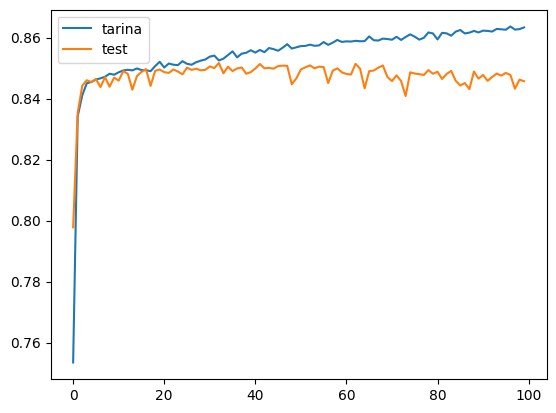

In [11]:
import matplotlib.pyplot as pl
plt.plot(history_sgd.history['accuracy'], label = "tarina")
plt.plot(history_sgd.history['val_accuracy'], label = "test")
plt.legend()
plt.show()

# Zad

Zbuduj i przetestuj sieć przestawioną na rysunku:

<img src="https://adeshpande3.github.io/assets/LeNet.png" width="700">
Źródło: https://adeshpande3.github.io/assets/LeNet.png"

In [18]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

# Budowa architektury sieci LeNet
model = tf.keras.Sequential()
model.add(layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(16, kernel_size=(5, 5), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='relu'))
model.add(layers.Dense(84, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# Kompilacja modelu
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Przygotowanie danych treningowych i testowych
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Przygotowanie danych w odpowiednim formacie i normalizacja
x_train = tf.image.resize(x_train, [32, 32])  # Przeskalowanie obrazów do rozmiaru 32x32
x_test = tf.image.resize(x_test, [32, 32])
x_train = tf.expand_dims(x_train, axis=-1)
x_test = tf.expand_dims(x_test, axis=-1)
x_train = x_train / 255.0
x_test = x_test / 255.0
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

# Trening modelu
model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

# Testowanie modelu na danych testowych
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

ValueError: ignored